In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from xgboost import XGBRegressor
import warnings
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("../data/laptop_part2_100k.csv")
data.head(10)

,brand,cpu_brand,ram_gb,storage_gb,storage_type,gpu_brand,dedicated_gpu_vram_gb,screen_size_inch,screen_type,resolution,...,release_year,os,region,user_rating,num_reviews,touchscreen,backlit_keyboard,fingerprint_reader,wifi6_supported,price_inr
0,LG,AMD,24.0,512.0,SSD,Intel,4,17.5,IPS,2560x1440,...,2021,Ubuntu,Europe,3.7,324.0,1,1,0,1,74001
1,LG,AMD,32.0,512.0,HDD,Intel,8,15.4,VA,3840x2160,...,2016,macOS,SE Asia,1.5,2260.0,0,1,0,0,78994
2,MSI,Intel,32.0,2048.0,NaN,AMD,6,13.9,TN,1920x1080,...,2022,Windows 11,SE Asia,2.8,4942.0,0,1,1,0,99716
3,Lenovo,AMD,24.0,512.0,HDD,NVIDIA,2,13.3,TN,1366x768,...,2021,Windows 11,Middle East,2.8,2469.0,1,0,0,1,70380
4,LG,Intel,16.0,512.0,Hybrid,Intel,4,14.4,OLED,3840x2160,...,2015,Windows 11,Middle East,4.1,1367.0,0,1,1,0,53944
5,Samsung,Apple Silicon,8.0,256.0,SSD,Intel,12,17.6,IPS,2560x1440,...,2022,Windows 11,Middle East,1.7,1835.0,1,1,1,0,72991
6,Lenovo,AMD,12.0,256.0,HDD,NVIDIA,4,11.4,VA,2560x1440,...,2024,macOS,USA,2.2,NaN,0,1,0,1,60948
7,HP,AMD,4.0,512.0,SSD,Intel,12,15.3,VA,1366x768,...,2022,Fedora,Middle East,3.5,2117.0,1,0,0,1,85867
8,Apple,Intel,12.0,NaN,NaN,Intel,6,14.0,VA,1920x1080,...,2019,macOS,Middle East,3.1,1331.0,1,1,0,0,60373
9,Acer,AMD,12.0,512.0,Hybrid,Intel,8,16.2,VA,1366x768,...,2018,Ubuntu,Europe,4.0,3654.0,0,1,1,1,75871


### EDA

In [3]:
data.isnull().sum()

brand                       0
cpu_brand                   0
ram_gb                   4948
storage_gb               5009
storage_type             5060
gpu_brand                4999
dedicated_gpu_vram_gb       0
screen_size_inch            0
screen_type                 0
resolution                  0
weight_kg                5136
battery_wh                  0
release_year                0
os                          0
region                      0
user_rating              4976
num_reviews              4858
touchscreen                 0
backlit_keyboard            0
fingerprint_reader          0
wifi6_supported             0
price_inr                   0
dtype: int64

In [4]:
data.shape

(100000, 22)

In [5]:
data.columns

Index(['brand', 'cpu_brand', 'ram_gb', 'storage_gb', 'storage_type',
       'gpu_brand', 'dedicated_gpu_vram_gb', 'screen_size_inch', 'screen_type',
       'resolution', 'weight_kg', 'battery_wh', 'release_year', 'os', 'region',
       'user_rating', 'num_reviews', 'touchscreen', 'backlit_keyboard',
       'fingerprint_reader', 'wifi6_supported', 'price_inr'],
      dtype='object')

In [6]:
outliers=[
    'brand', 'cpu_brand', 'ram_gb', 'storage_gb', 'storage_type',
       'gpu_brand', 'dedicated_gpu_vram_gb', 'screen_size_inch', 'screen_type',
       
]

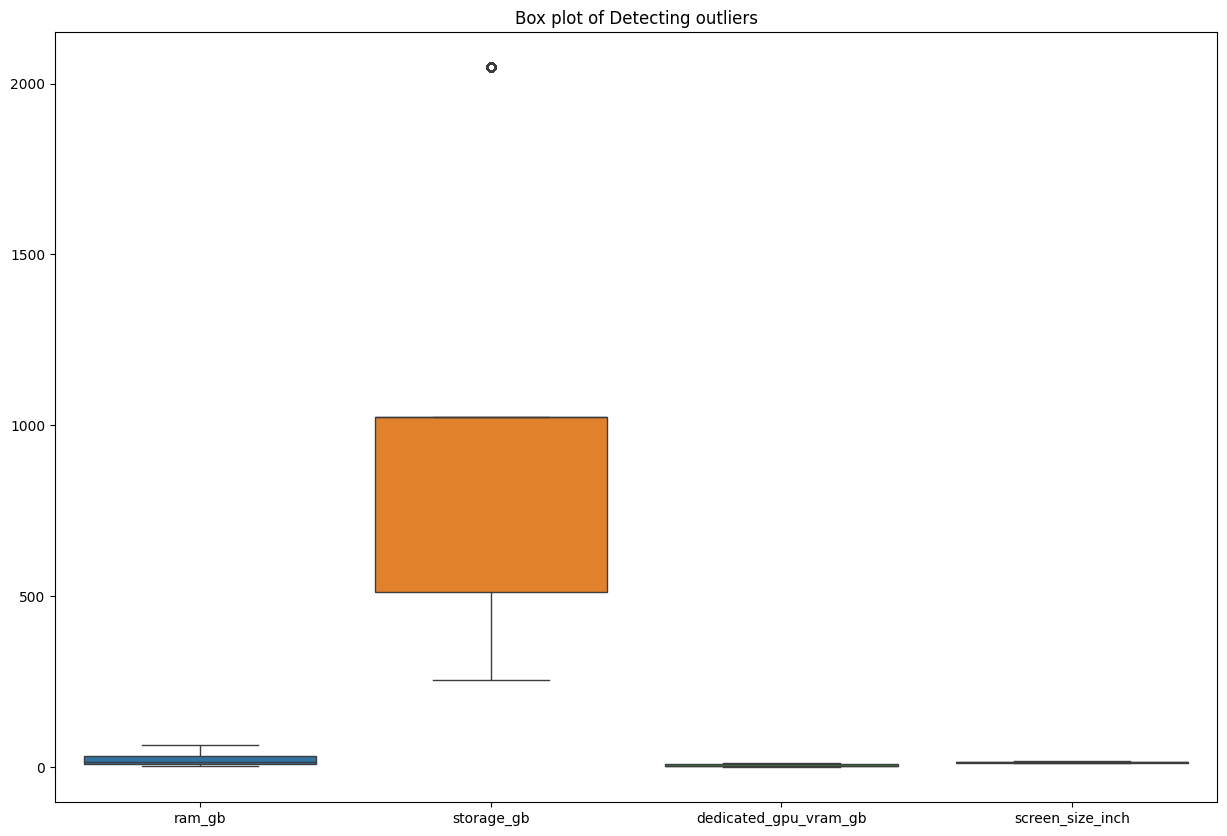

In [7]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data[outliers])
plt.title("Box plot of Detecting outliers")
plt.show()

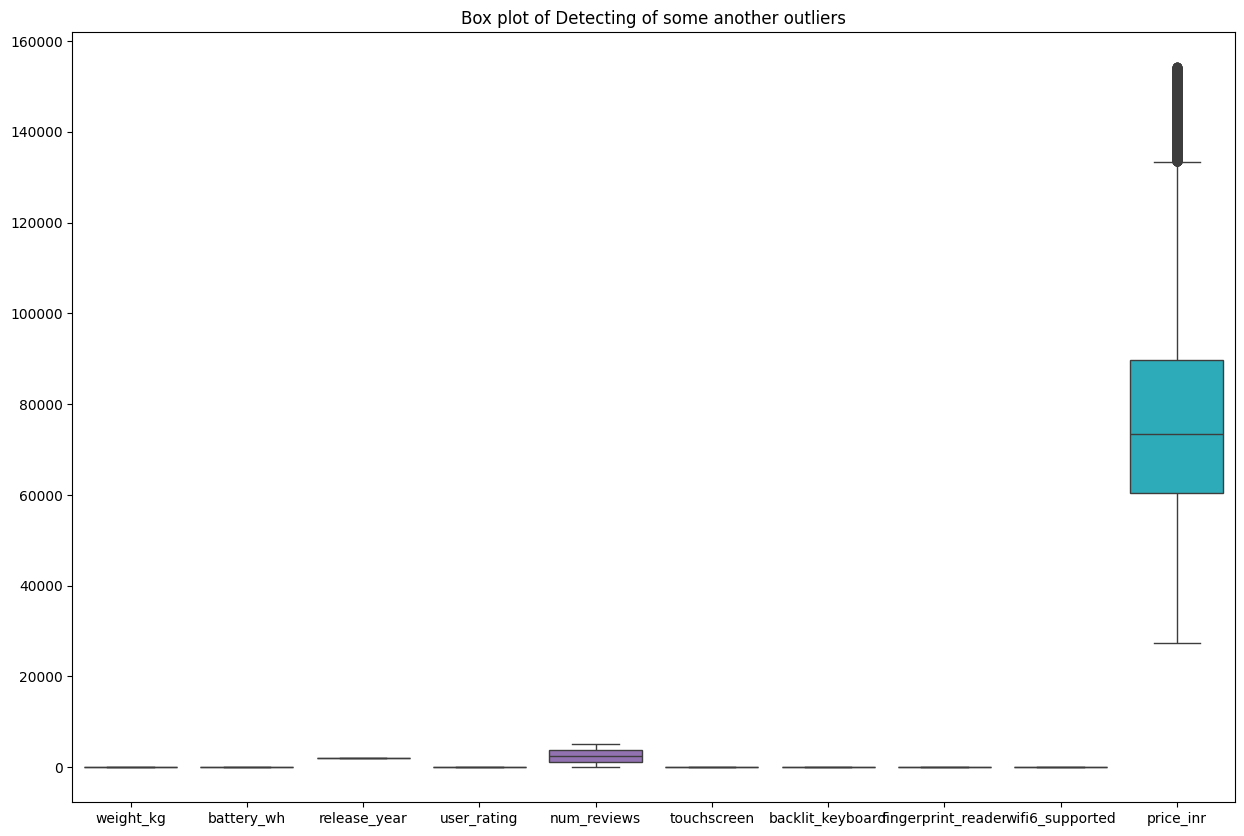

In [8]:
outliers1=[
    'resolution', 'weight_kg', 'battery_wh', 'release_year', 'os', 'region',
       'user_rating', 'num_reviews', 'touchscreen', 'backlit_keyboard',
       'fingerprint_reader', 'wifi6_supported', 'price_inr']
plt.figure(figsize=(15,10))
sns.boxplot(data=data[outliers1])
plt.title("Box plot of Detecting of some another outliers")
plt.show()

### Filling some null values 

In [9]:
data.describe()

,ram_gb,storage_gb,dedicated_gpu_vram_gb,screen_size_inch,weight_kg,battery_wh,release_year,user_rating,num_reviews,touchscreen,backlit_keyboard,fingerprint_reader,wifi6_supported,price_inr
count,95052.000000,94991.000000,100000.000000,100000.000000,94864.000000,100000.000000,100000.000000,95024.000000,95142.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,22.944536,959.339053,5.334460,14.496719,2.251946,63.239970,2019.486750,3.003409,2496.521662,0.499260,0.500080,0.501330,0.499650,77059.745710
std,18.992968,685.481720,3.944714,2.026638,0.721651,21.393726,2.873069,1.155044,1447.480520,0.500002,0.500002,0.500001,0.500002,23111.279457
min,4.000000,256.000000,0.000000,11.000000,1.000000,35.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27307.000000
25%,8.000000,512.000000,2.000000,12.700000,1.630000,45.000000,2017.000000,2.000000,1241.000000,0.000000,0.000000,0.000000,0.000000,60498.000000
50%,16.000000,1024.000000,4.000000,14.500000,2.260000,65.000000,2019.000000,3.000000,2494.000000,0.000000,1.000000,1.000000,0.000000,73304.500000
75%,32.000000,1024.000000,8.000000,16.300000,2.880000,80.000000,2022.000000,4.000000,3754.000000,1.000000,1.000000,1.000000,1.000000,89682.000000
max,64.000000,2048.000000,12.000000,18.000000,3.500000,99.000000,2024.000000,5.000000,4999.000000,1.000000,1.000000,1.000000,1.000000,154237.000000


In [10]:
data["ram_gb"].fillna(data["ram_gb"].mean(),inplace=True)

In [11]:
data["storage_gb"].fillna(data["storage_gb"].mean(),inplace=True)

In [12]:
data["storage_type"] = data["storage_type"].fillna(data["storage_type"].mode()[0])

In [13]:
data["gpu_brand"] = data["gpu_brand"].fillna(data["gpu_brand"].mode()[0])

In [14]:
data["weight_kg"].fillna(data["weight_kg"].mean(),inplace=True)

In [15]:
data["user_rating"].fillna(data["user_rating"].mean(),inplace=True)

In [16]:
data["num_reviews"].fillna(data["num_reviews"].mean(),inplace=True)

In [17]:
data.isnull().sum()

brand                    0
cpu_brand                0
ram_gb                   0
storage_gb               0
storage_type             0
gpu_brand                0
dedicated_gpu_vram_gb    0
screen_size_inch         0
screen_type              0
resolution               0
weight_kg                0
battery_wh               0
release_year             0
os                       0
region                   0
user_rating              0
num_reviews              0
touchscreen              0
backlit_keyboard         0
fingerprint_reader       0
wifi6_supported          0
price_inr                0
dtype: int64

In [18]:
outliers_Fill=[
    'brand', 'cpu_brand', 'ram_gb', 'storage_gb', 'storage_type',
       'gpu_brand', 'dedicated_gpu_vram_gb', 'screen_size_inch', 'screen_type',
       
]

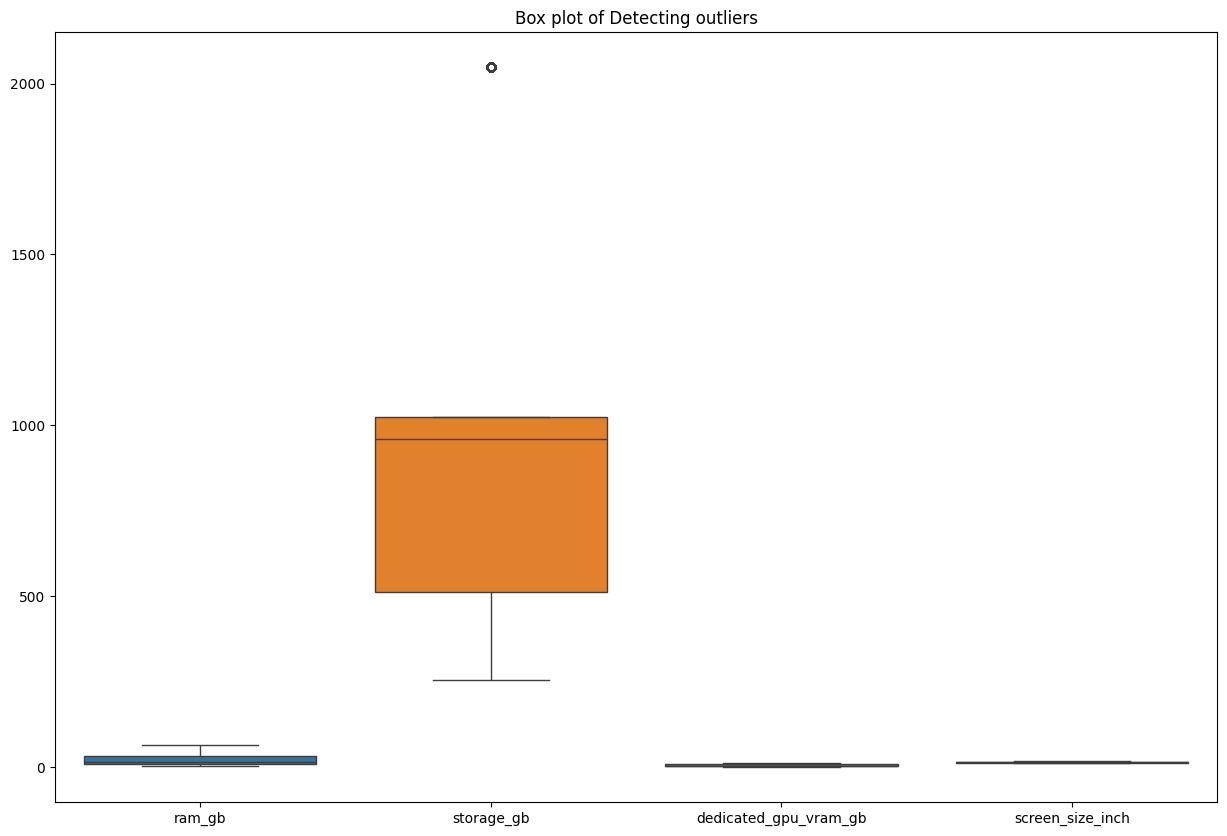

In [19]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data[outliers_Fill])
plt.title("Box plot of Detecting outliers")
plt.show()

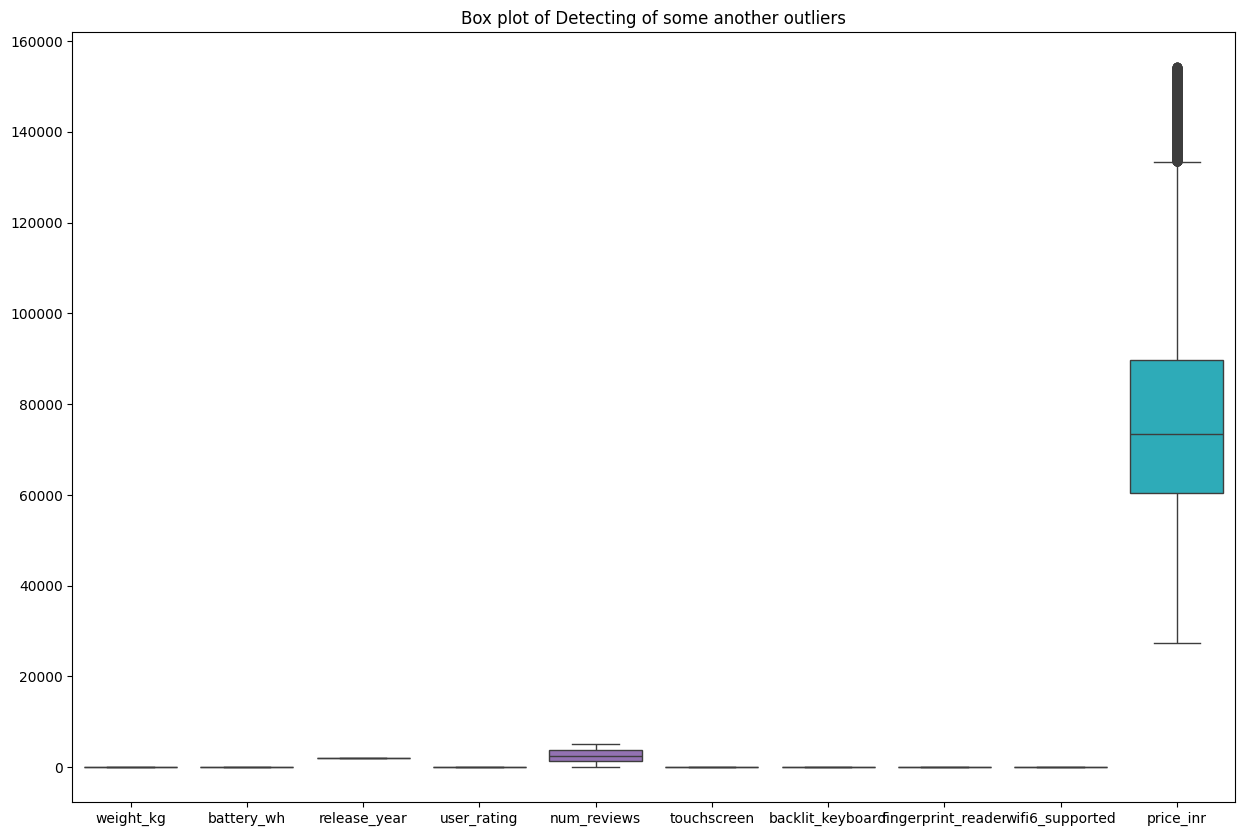

In [20]:
outliers1=[
    'resolution', 'weight_kg', 'battery_wh', 'release_year', 'os', 'region',
       'user_rating', 'num_reviews', 'touchscreen', 'backlit_keyboard',
       'fingerprint_reader', 'wifi6_supported', 'price_inr']
plt.figure(figsize=(15,10))
sns.boxplot(data=data[outliers1])
plt.title("Box plot of Detecting of some another outliers")
plt.show()

### Some Visulization

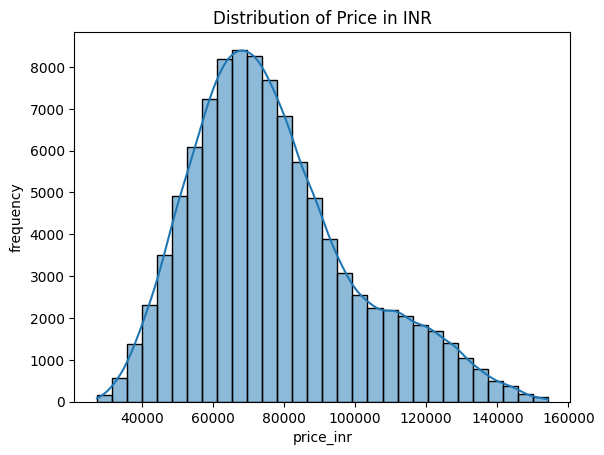

In [21]:
plt.figuresize=((15,10))
sns.histplot(data['price_inr'],bins=30,kde=True)
plt.title("Distribution of Price in INR")
plt.xlabel("price_inr")
plt.ylabel("frequency")
plt.show()

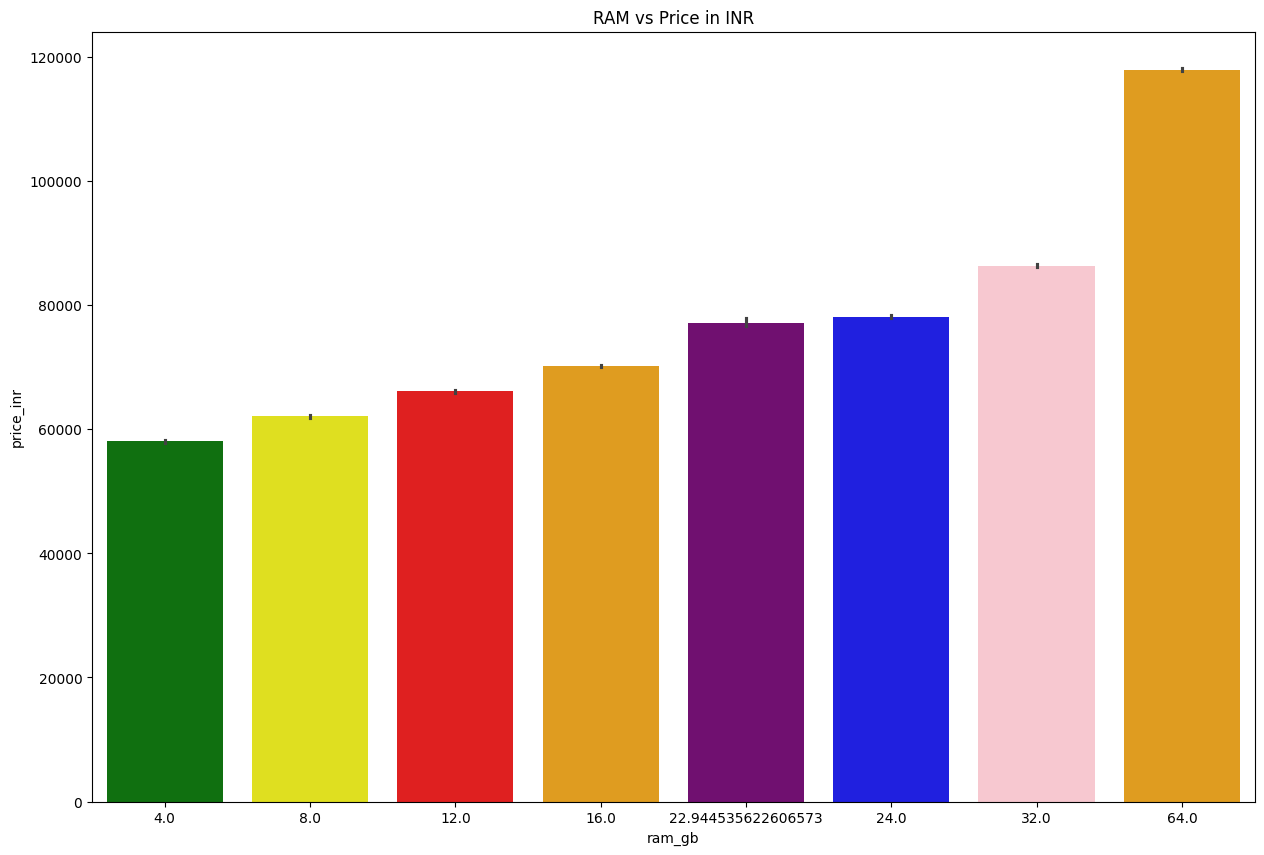

In [22]:
plt.figure(figsize=(15,10))
colors=["green","yellow","red","orange","purple","blue","pink","orange","magenta"]
sns.barplot(x=data["ram_gb"],y=data["price_inr"],palette=colors)
plt.title("RAM vs Price in INR")
plt.show()

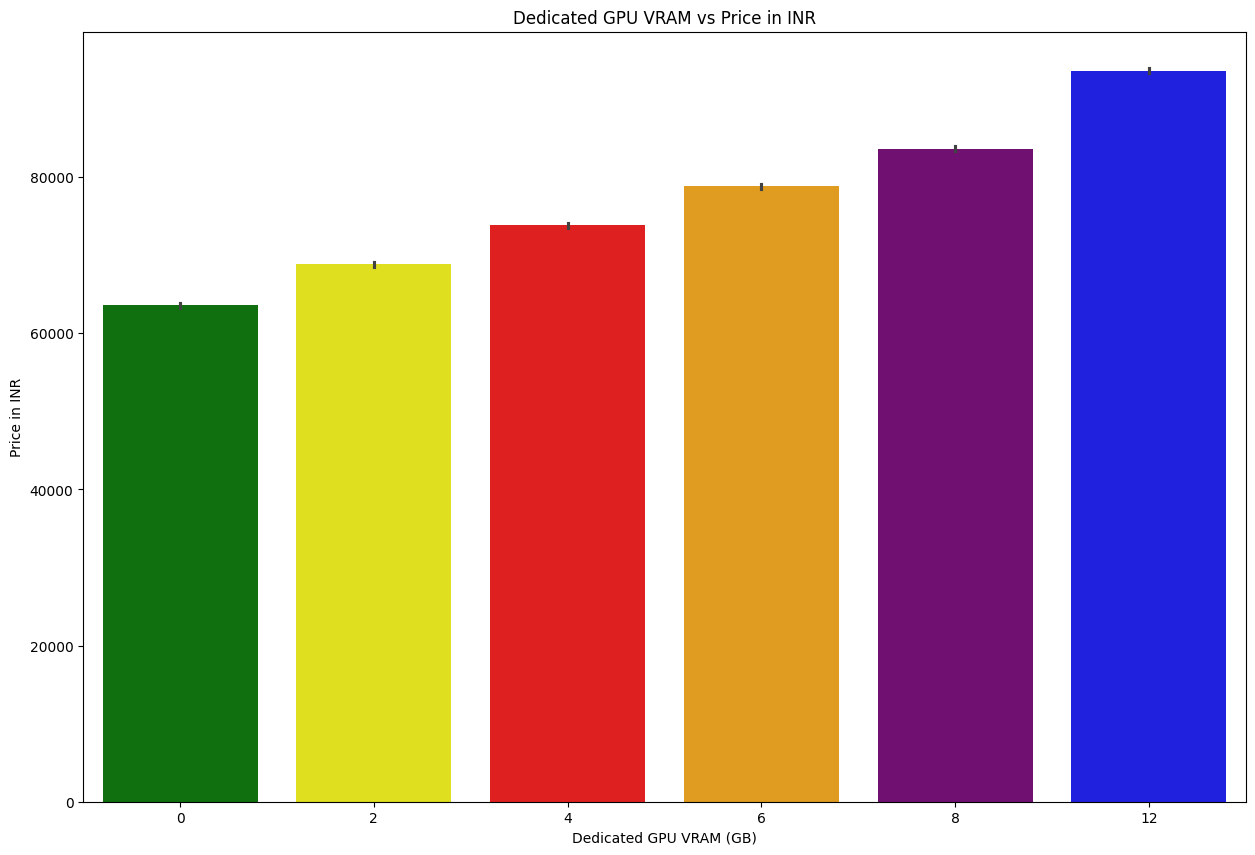

In [ ]:
plt.figure(figsize=(15,10))
colors=["green","yellow","red","orange","purple","blue","pink"]
sns.barplot(x=data["dedicated_gpu_vram_gb"],y=data["price_inr"],palette=colors)
plt.title("Dedicated GPU VRAM vs Price in INR")
plt.xlabel("Dedicated GPU VRAM (GB)")
plt.ylabel("Price in INR")
plt.show()

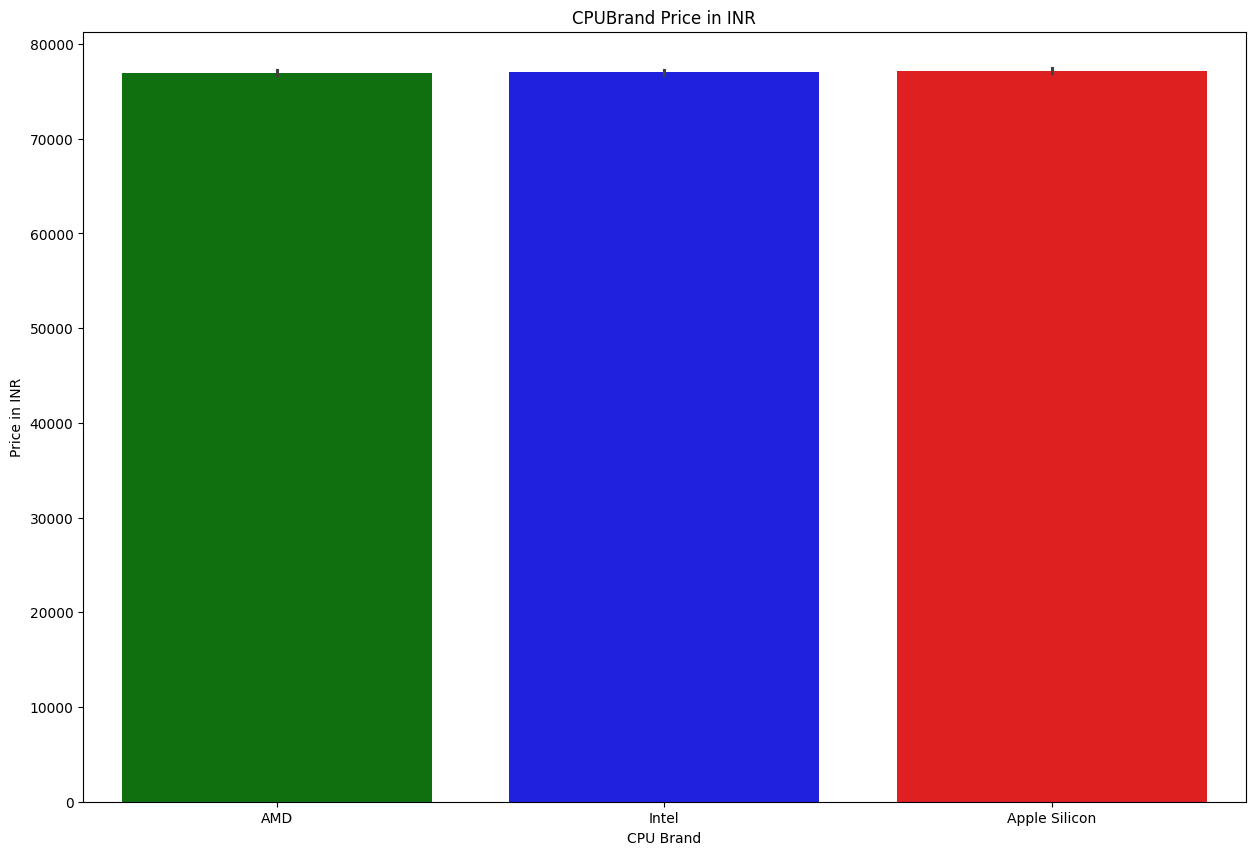

In [24]:
plt.figure(figsize=(15,10))
colors=["green","blue","red"]
sns.barplot(x=data["cpu_brand"],y=data["price_inr"],palette=colors)
plt.title("CPUBrand Price in INR")
plt.xlabel("CPU Brand")
plt.ylabel("Price in INR")
plt.show()

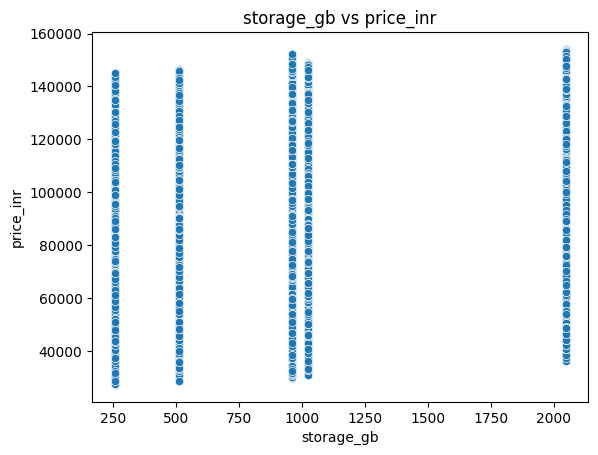

In [25]:
sns.scatterplot(x=data["storage_gb"],y=data["price_inr"])
plt.title("storage_gb vs price_inr")
plt.show()

### Converting Categorical to Numerical

In [26]:
cat_cols=['brand', 'cpu_brand', 'ram_gb', 'storage_gb', 'storage_type',
       'gpu_brand', 'dedicated_gpu_vram_gb', 'screen_size_inch', 'screen_type',
       'resolution', 'weight_kg', 'battery_wh', 'release_year', 'os', 'region',
       'user_rating', 'num_reviews', 'touchscreen', 'backlit_keyboard',
       'fingerprint_reader', 'wifi6_supported', 'price_inr']

In [27]:
for col in cat_cols:
    if data[col].dtype=="object":
        data[col]=LabelEncoder().fit_transform(data[col])

### Feature  Engineering

In [28]:
x=data.drop("price_inr",axis=1)
y=data["price_inr"]

In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((80000, 21), (20000, 21), (80000,), (20000,))

### Linear Model

In [30]:
model=LinearRegression()
model

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [31]:
model.fit(x_train,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [32]:
yhat_train=model.predict(x_train)
yhat_test=model.predict(x_test)

In [33]:
print(mean_squared_error(y_train,yhat_train))
print(r2_score(y_train,yhat_train))

83742157.53374934
0.8430959727092135


In [34]:
print(mean_squared_error(y_test,yhat_test))
print(r2_score(y_test,yhat_test))

84256199.26508754
0.8427340233131966


### Pipelining

In [35]:
categorical = ['brand','cpu_brand','storage_type','gpu_brand','os','region','screen_type']
numeric = ['ram_gb','storage_gb','dedicated_gpu_vram_gb','screen_size_inch','resolution','release_year','user_rating','num_reviews','touchscreen','backlit_keyboard','fingerprint_reader','wifi6_supported']


In [36]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numeric)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

In [37]:
pipeline.fit(x_train,y_train) 

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [38]:
train_pipeline=pipeline.predict(x_train)
test_pipeline=pipeline.predict(x_test)

In [39]:
print("Train MSE :",mean_squared_error(y_train,train_pipeline))
print("Train R2 Score :",r2_score(y_train,train_pipeline))

Train MSE : 83727861.30572508
Train R2 Score : 0.8431227589279847


In [40]:
print("Test MSE :",mean_squared_error(y_test,test_pipeline))
print("Test R2 Score :",r2_score(y_test,test_pipeline))

Test MSE : 84273696.99325268
Test R2 Score : 0.8427013634337611


In [56]:
pickle.dump(pipeline, open("laptop.pkl","wb"))